Customers Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 

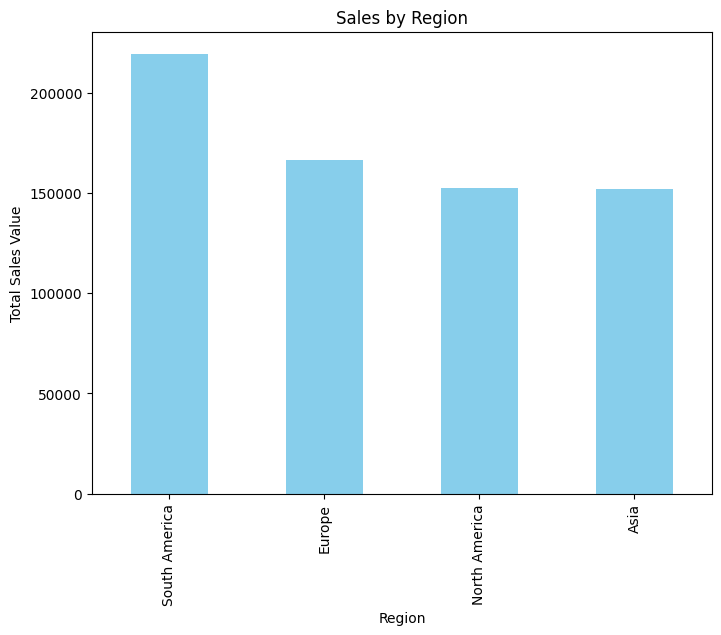

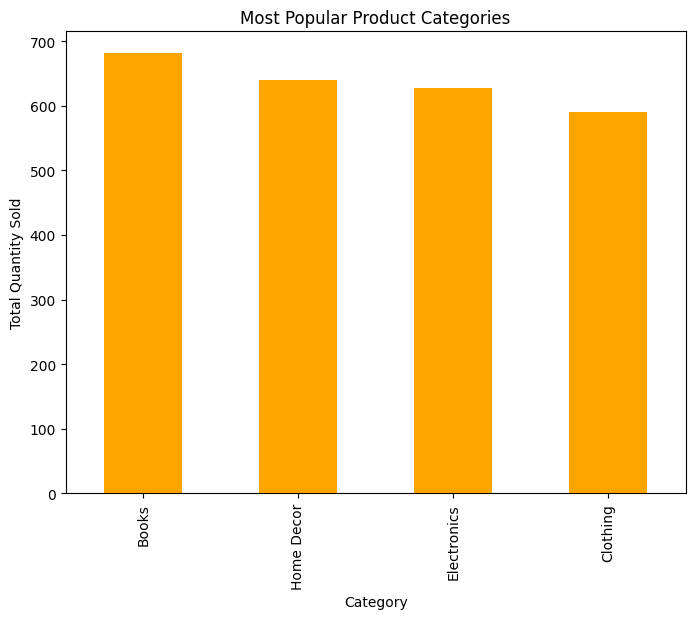

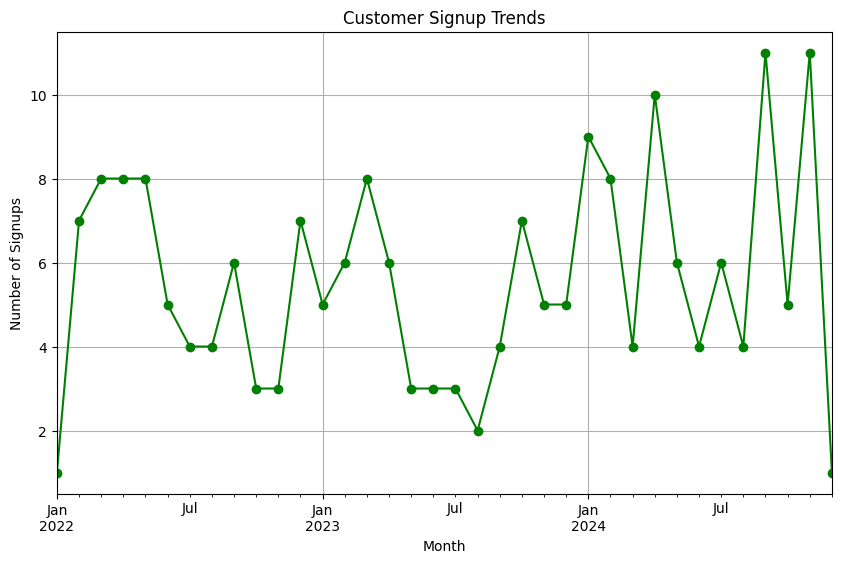

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv("/content/Customers.csv")
products = pd.read_csv("/content/Products.csv")
transactions = pd.read_csv("/content/Transactions.csv")

# Inspect datasets
print("Customers Data")
print(customers.info())
print(customers.head())

print("\nProducts Data")
print(products.info())
print(products.head())

print("\nTransactions Data")
print(transactions.info())
print(transactions.head())

# Check for missing values
print("\nMissing Values:")
print("Customers:", customers.isnull().sum())
print("Products:", products.isnull().sum())
print("Transactions:", transactions.isnull().sum())

# Merge datasets for analysis
merged = transactions.merge(customers, on="CustomerID", how="inner") \
                     .merge(products, on="ProductID", how="inner")

# Basic statistics
print("\nSummary Statistics:")
print(merged.describe())

# EDA: Sales by region
sales_by_region = merged.groupby("Region")["TotalValue"].sum().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sales_by_region.plot(kind="bar", color="skyblue")
plt.title("Sales by Region")
plt.xlabel("Region")
plt.ylabel("Total Sales Value")
plt.show()

# EDA: Popular product categories
popular_categories = merged.groupby("Category")["Quantity"].sum().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
popular_categories.plot(kind="bar", color="orange")
plt.title("Most Popular Product Categories")
plt.xlabel("Category")
plt.ylabel("Total Quantity Sold")
plt.show()

# EDA: Customer signup trends
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
signup_trends = customers["SignupDate"].dt.to_period("M").value_counts().sort_index()
plt.figure(figsize=(10, 6))
signup_trends.plot(kind="line", marker="o", color="green")
plt.title("Customer Signup Trends")
plt.xlabel("Month")
plt.ylabel("Number of Signups")
plt.grid(True)
plt.show()


In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Merge datasets
data = transactions.merge(customers, on="CustomerID", how="inner") \
                   .merge(products, on="ProductID", how="inner")

# Feature engineering: Aggregate transaction data
customer_data = data.groupby("CustomerID").agg({
    "Quantity": "sum",
    "TotalValue": "sum",
    "Region": "first",  # Take the first region (assumes it's consistent)
    "Category": lambda x: x.mode()[0]  # Most frequent category
}).reset_index()

# Encode categorical features
le_region = LabelEncoder()
le_category = LabelEncoder()
customer_data["Region"] = le_region.fit_transform(customer_data["Region"])
customer_data["Category"] = le_category.fit_transform(customer_data["Category"])

# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ["Quantity", "TotalValue"]
customer_data[numerical_cols] = scaler.fit_transform(customer_data[numerical_cols])

# Compute similarity matrix
features = customer_data[["Region", "Category"] + numerical_cols].values
similarity_matrix = cosine_similarity(features)

# Recommend top 3 lookalikes for each customer
lookalike_results = {}
for i, customer_id in enumerate(customer_data["CustomerID"][:20]):  # First 20 customers
    similar_indices = np.argsort(similarity_matrix[i])[-4:-1][::-1]  # Top 3 excluding self
    lookalikes = [(customer_data["CustomerID"].iloc[j], similarity_matrix[i, j]) for j in similar_indices]
    lookalike_results[customer_id] = lookalikes

# Save results to CSV
import csv

with open("Sayali_Chougule_Lookalike.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["CustomerID", "Lookalikes"])
    for cust_id, lookalikes in lookalike_results.items():
        writer.writerow([cust_id, lookalikes])

print("Sayali_Chougule_Lookalike.csv has been created.")


Sayali_Chougule_Lookalike.csv has been created.


Optimal number of clusters: 9
Davies-Bouldin Index: 0.9493364460696956


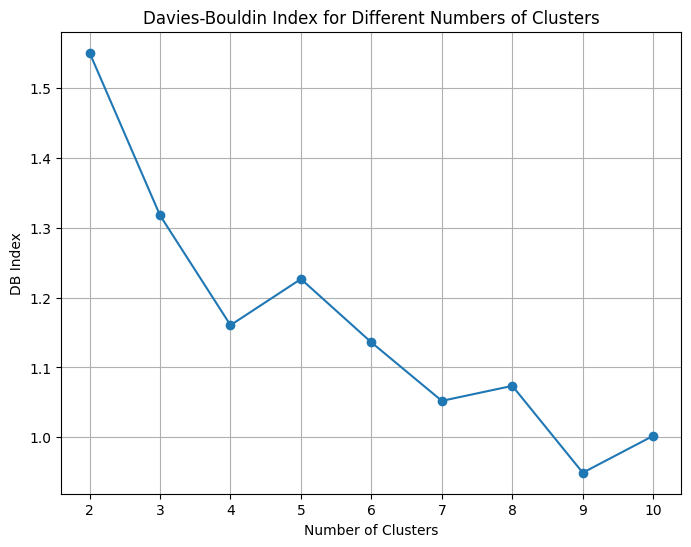

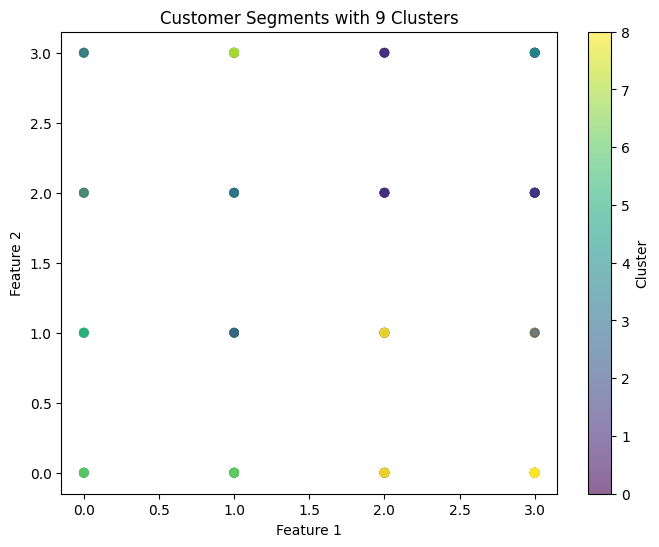

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Clustering
db_scores = []
cluster_range = range(2, 11)
best_model = None
best_score = float('inf')

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)
    score = davies_bouldin_score(features, labels)
    db_scores.append(score)
    if score < best_score:
        best_score = score
        best_model = kmeans

# Best number of clusters
best_k = cluster_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {best_k}")
print(f"Davies-Bouldin Index: {best_score}")

# Visualization
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, db_scores, marker="o")
plt.title("Davies-Bouldin Index for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.grid(True)
plt.show()

# Visualize clusters (2D projection using first two features)
plt.figure(figsize=(8, 6))
plt.scatter(features[:, 0], features[:, 1], c=best_model.labels_, cmap="viridis", alpha=0.6)
plt.title(f"Customer Segments with {best_k} Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster")
plt.show()
